# Experiment 7 figure generation and statistics

In [4]:
import pickle as pkl
import pandas as pd
import numpy as np
from pathlib import Path

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# So that we can edit the text in illustrator
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
fig_out_dir = Path("final_figures/figure_4")
fig_out_dir.mkdir(exist_ok=True, parents=True)


import seaborn as sns
from src import util_analysis 
from src import util_process_prolific as util_process
import re

In [5]:
fig_out_dir = Path("final_figures/figure_4")
fig_out_dir.mkdir(exist_ok=True, parents=True)

## Plot main figure

##### Load data

In [6]:
results_dir = Path("final_results_to_share")
results_df = pd.read_csv(results_dir / "experiment_7_df.csv")

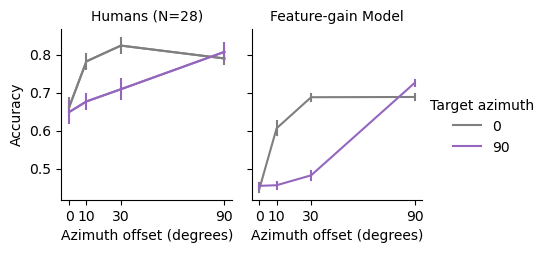

In [8]:
hue_order = [0,  90]

cmap = sns.color_palette('tab10', n_colors=8)
palette={}
palette[0] = cmap[7]
palette[90] = cmap[4]

col_order = ['Humans (N=28)', 'Feature-gain Model',]# 'Early-only', 'Late-only', 'Baseline CNN']
to_plot = results_df.copy()
to_plot.rename(columns={'target_azim':'Target azimuth'}, inplace=True)
# to_plot.loc[to_plot.model.str.contains('arch|main'), 'group'] = 'Feature-gain Model'

g = sns.relplot(data=to_plot, x='azim_delta', y='accuracy',
                 hue='Target azimuth', hue_order=hue_order,
                 col='group', col_order=col_order,
                 errorbar=('se', 1),
                 err_style='bars',
                height=3,
                palette=palette,
                kind='line', aspect=0.75)
# set xticks to be the same as the azimuth deltas
g.set(xticks=results_df['azim_delta'].unique(), yticks=np.arange(0.40, .91, 0.1))
g.set_titles("{col_name}")
# plt.title(f"N={N} participants")
g.set_axis_labels("Azimuth offset (degrees)", "Accuracy")


# add error to human plot 
for group, selected in to_plot[to_plot.group.str.contains('Human')].groupby('Target azimuth'):
    # plot the errorbar with the correct color for each group 
    sem = selected['accuracy_sem'] 
    # add errorbar as fill_between 
    g.axes[0,0].errorbar(selected['azim_delta'], selected['accuracy'], yerr=sem, color=palette[group], alpha=1)



# make aspect square

ratio = 1 

for ax in g.axes.flat:
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

# g.savefig(fig_out_dir / "figure_4_model_human_accuracy.pdf", transparent=True, bbox_inches='tight')

## Run stats on human results

In [10]:
human_results_for_ANOVA = pd.read_csv(results_dir / "experiment_7_human_for_ANOVA.csv")

In [12]:
from pingouin import rm_anova

human_rm_anova_table = rm_anova(data=human_results_for_ANOVA, dv='correct_mean', subject='participant', within=["target_azim", 'distractor_offset'], effsize='np2')
print("ANOVA for humans")
human_rm_anova_table

ANOVA for humans


/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,target_azim,0.163438,1,27,0.163438,7.684569,9.966202e-03,9.966202e-03,0.221556,1.000000
1,distractor_offset,0.636462,3,81,0.212154,30.319909,3.057243e-13,5.500018e-13,0.528959,0.976882
2,target_azim * distractor_offset,0.183353,3,81,0.061118,6.730875,4.120668e-04,1.292766e-03,0.199546,0.785780


## Plot practice effect

In [13]:
human_practice_effect_df = pd.read_csv(results_dir / "experiment_7_human_practice_effect_summary.csv")

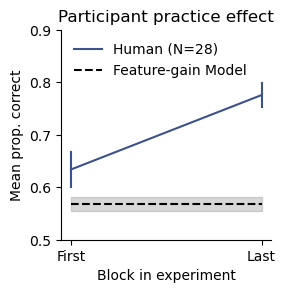

In [19]:
### Simplify practice effect plot
model_acc_mean, model_acc_sem = results_df[results_df.group == 'Feature-gain Model'].accuracy.agg(['mean', 'sem'])
to_plot = human_practice_effect_df.copy()
N = to_plot.participant.nunique()

# get model human difference 
# to_plot.loc[to_plot.azim_delta == 0, 'performance_delta'] = to_plot.loc[to_plot.azim_delta == 0, 'correct_mean'] - model_acc_at_0
to_plot['performance_delta'] = to_plot['correct_mean'] - model_acc_mean

cmap = sns.color_palette('Set2', n_colors=2)
palette = {target_azim: cmap[i] for i, target_azim in enumerate([0, 90])}


human_color = sns.color_palette("viridis", as_cmap=True)(0.25)

g = sns.relplot(data=to_plot, x='block_ix', y='correct_mean',
            # hue='azim_delta', # hue_order=hue_order,
            errorbar=('se', 1),err_style='bars',
            height=3,
            color=human_color,
            kind='line', aspect=1)
g.set(xticks=[0,3], xticklabels=['First', 'Last'], )
# add error bar for model mean accuracy
ax = g.axes[0,0]
ax.plot([0,3], [model_acc_mean] *2, '--k')
ax.set_ylim(0.5,.9)

## Add legend manually 

legend_handles = [
    Line2D([0], [0], marker='', color=human_color,
           label=f"Human (N={N})",
           markerfacecolor=human_color,
           )
           ,   
        Line2D([0], [0], ls='--', color='k',
           label=f"Feature-gain Model",
           markerfacecolor='k',
           )
            ]

fontsize=10

color_legend = ax.legend(handles=legend_handles, title="", frameon=False,
                              loc='upper left', fontsize=fontsize, title_fontsize=fontsize,
                              bbox_to_anchor=(0, 1),
                            #   bbox_transform=fig.transFigure
                              ) 
ax.fill_between([0,3], model_acc_mean + model_acc_sem,  model_acc_mean - model_acc_sem, alpha=0.3, color='grey')
# g.fig.suptitle(f"Accuracy improvement over experiment (N={N})", y=1.05)
g.set_axis_labels("Block in experiment", "Mean prop. correct")
# g.legend.set_title("Azimuth\noffset\n(degrees)")
ax.set_title('Participant practice effect', fontsize=12,)

## Make panel aspect square 
ratio = 1.0 
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

# g.savefig(fig_out_dir / "figure_4_model_practice_effect.pdf", transparent=True, bbox_inches='tight')